In [1]:
import logging
import pandas as pd
import geopandas
import eust
import matplotlib as mpl
import matplotlib.pyplot as plt
import hierarchy
import nuts
import settings
import plots
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

# Set some constants

## Exclude data with some flags

In [2]:
eust.read_table_metadata('ef_lus_allcrops')['attributes']

label
attribute  code                                                      
OBS_FLAG   OBS_FLAG                                 Observation flag.
           b                                     break in time series
           c                                             confidential
           d                         definition differs, see metadata
           e                                                estimated
           f                                                 forecast
           i                                see metadata (phased out)
           n                                          not significant
           p                                              provisional
           r                                                  revised
           s                           Eurostat estimate (phased out)
           u                                          low reliability
           z                                           not applicable
OBS_STATUS OBS_STATUS                             Observation status.
           -           not applicable or real zero or zero by default
           0                          less than half of the unit used
           na                                           not available

In [3]:
# Eurostat data flags where to drop the data
EXCLUDED_FLAGS = ['u']

## Read NUTS nomenclature data

In [4]:
NUTS_TABLE = nuts.get_nuts_candidates()
EU28_COUNTRIES = NUTS_TABLE.country_code.unique()
NUTS_TABLE

,country_code,nuts_level,label,parent_geo,country
geo,,,,,
AT,AT,0,ÖSTERREICH,NaN,Austria
AT1,AT,1,OSTÖSTERREICH,AT,Austria
AT11,AT,2,Burgenland (AT),AT1,Austria
AT12,AT,2,Niederösterreich,AT1,Austria
AT13,AT,2,Wien,AT1,Austria
...,...,...,...,...,...
UKM3,UK,2,South Western Scotland,UKM,United Kingdom
UKM5,UK,2,North Eastern Scotland,UKM,United Kingdom
UKM6,UK,2,Highlands and Islands,UKM,United Kingdom


# Crop production calculation

In [5]:
NON_PRODUCTIVE_CROPS = ['Q0000', 'J3000']

In [6]:
CROP_PARTITIONS = {
    'UAA': ['ARA', 'J0000', 'PECR', 'K0000'],
    'PECR': ['H0000', 'L0000', 'PECR9'],
    'ARA': ['C0000', 'P0000', 'R0000', 'I0000', 'G0000', 'V0000_S0000', 'ARA9', 'Q0000'],
    'C0000': ['C1000', 'C2000'],
    'C1000': ['C1000X1500', 'C1500'],
    'C1000X1500': ['C1100', 'C1200', 'C1300', 'C1400', 'C1600_1700_1900'],
    'C1600_1700_1900': ['C1600', 'C1700', 'C1900'],
    'C2000': ['C2100', 'C2200'],
    'C1100': ['C1110', 'C1120'],
    'C1110': ['C1111', 'C1112'],
    'C1200': ['C1210', 'C1220'],
    'C1300': ['C1310', 'C1320'],
    'C1400': ['C1410', 'C1420'],
    'I0000': ['I1100','I2000','I3000','I4000','I5000','I6000_9000'],
    'I1100': ['I1110-1140', 'I1150', 'I1190'],
    'I1110-1140': ['I1110-1130', 'I1140'],
    'I1110-1130': ['I1110', 'I1120', 'I1130'],
    'P0000': ['P1000', 'P9000'],
    'P1000': ['P1100', 'P1200', 'P1300'],
    'R0000': ['R1000', 'R2000', 'R9000'],
    'J0000': ['J1000', 'J2000', 'J3000'],
    'J3000': ['J3000ES',],
    'G0000': ['G1000', 'G2000', 'G3000', 'G9000'],
    'G2000': ['G2100','G2900'],
    'G9000': ['G9100','G9900'],
    'H0000': ['F0000', 'T0000', 'W1000', 'O1000', 'H9000'],
    'W1000': ['W1100', 'W1200', 'W1300', 'W1900'],
    'W1100': ['W1110_1120', 'W1190'],
    'W1110_1120': ['W1110', 'W1120'],
    'O1000': ['O1100', 'O1900'],
    'O1900': ['O1910', 'O1990'],
    'T0000': ['T1000', 'T2000', 'T3000', 'T4000', 'T9000'],
}

## Set P concentrations for crops and subcrops

In [7]:
INCLUDED_CROPS = [
    'C1000X1500',
    'C1500',
    'C2000',
    'G0000',
    'J1000',
    'J2000',
    'J3000',
    'I1110',
    'I1120',
    'I1130',
    'I1140',
    'I1150',
    'P0000',
    'R0000',
    'T0000',
    'W1000',
    'O1000',
    'Q0000',
]

# DM = dry matter; FW = fresh weight
P_CONC = {
    # g/kg
    ('C1000X1500', 'DM'): 3.6, # Based on Feedipedia
    ('C1500', 'DM'): 3.0, # Feedipedia
    ('C2000', 'FW'): 2.9, # IPNI
    ('G1000', 'DM'): 2.3, # IPNI ryegrass: 2.6; VERA grass silage: 2.2; Feedipedia timothy: 2.0
    ('J0000', 'DM'): 2.3, # IPNI ryegrass: 2.6; VERA grass silage: 2.2; Feedipedia timothy: 2.0
    ('G2000', 'DM'): 3.0, # Feedipedia Red clover: 3.4; Feedipedia Alfalfa: 2.7
    ('G3000', 'DM'): 2.1, # Feedipedia maize green forage: 2.1
    ('G9000', 'DM'): 2.5, # Mean of other G crops
    ('I1110', 'DM'): 7.3, # Feedipedia
    ('I1120', 'DM'): 6.0, # Feedipedia
    ('I1130', 'DM'): 6.1, # Feedipedia
    ('I1140', 'DM'): 6.3, # Feedipedia
    ('I1150', 'DM'): 5.9, # Feedipedia
    ('R1000', 'FW'): 0.7, # IPNI
    ('R2000', 'FW'): 0.5, # IPNI
    ('T0000', 'FW'): 0.4, # IPNI oranges
    ('W1000', 'FW'): 0.6, # Oklahoma State University (ref)
    ('O1000', 'FW'): 0.5, # Férnandez-Escobar et al. (2015)
}

P_FRAC = (
    pd.Series(P_CONC)
    .div(1e3) # to fraction
    .rename('p_frac')
    .rename_axis(['crops', 'basis'])
    .pipe(hierarchy.fill_copy_to_children, CROP_PARTITIONS, level='crops', iterate=True)
)
P_FRAC

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


crops       basis
C1000X1500  DM       0.0036
C1100       DM       0.0036
C1110       DM       0.0036
C1111       DM       0.0036
C1112       DM       0.0036
                      ...  
W1120       FW       0.0006
W1190       FW       0.0006
W1200       FW       0.0006
W1300       FW       0.0006
W1900       FW       0.0006
Name: p_frac, Length: 63, dtype: float64

## Load area data from FSS  (table `ef_lus_allcrops`)

In [8]:
def fill_nuts_crops_iter(s):
    n = len(s)
    logger.debug(f'Original length {n}')
    do_more = True
    while do_more:
        s = nuts.fill_nuts(s)
        n_nuts = len(s)        
        logger.debug(f'Filled {len(s) - n} using NUTS hierarchy')
        s = hierarchy.fill_sum_aggregates(s, CROP_PARTITIONS, level='crops', iterate=True)
        logger.debug(f'Filled {len(s) - n_nuts} using crop hierarchy')
        do_more = len(s) > n
        n = len(s)
    logger.debug(f'Final length {len(s)}')
    return s

In [9]:
A = (
    eust.read_table_data('ef_lus_allcrops')
    .xs('TOTAL', level='agrarea')
    .xs('HA', level='unit')
    .xs(settings.DATA_YEAR, level='time')
    .loc[lambda d: ~d.flag.isin(EXCLUDED_FLAGS)]
    .value
    .reorder_levels(['geo', 'crops'])
    .mul(1e-6) # to Mha
    .dropna()
    .sort_index()
    .pipe(fill_nuts_crops_iter)
)
A

DEBUG:__main__:Original length 19949
DEBUG:__main__:Filled 5888 using NUTS hierarchy
DEBUG:__main__:Filled 1713 using crop hierarchy
DEBUG:__main__:Filled 0 using NUTS hierarchy
DEBUG:__main__:Filled 0 using crop hierarchy
DEBUG:__main__:Final length 27550


geo   crops        
AT    ARA              1.36386
      ARA99            0.00460
      C0000            0.82159
      C1000            0.82159
      C1000X1500       0.58794
                        ...   
UKN0  V0000_S0000TO    0.00131
      W1000            0.00000
      W1190            0.00000
      W1200            0.00000
      W1300            0.00000
Name: value, Length: 27550, dtype: float64

## Fill J1000, J2000, J3000 areas in some cases

When the parent J0000 and all children but one are known, the last can be deduced. This is needed to ensure coverage of all the reference areas below.

In [10]:
def calculate_single_missing_children(d, parent, children):
    items = [parent, *children]
    rows_to_be_filled = (
        d
        .loc[lambda d: ~d[parent].isnull()]
        .loc[lambda d: d[children].isnull().sum(axis=1) == 1]
    )
    
    fill_values = rows_to_be_filled[parent] - rows_to_be_filled[children].sum(axis=1)
    
    return (
        rows_to_be_filled
        .apply(lambda col: col.fillna(fill_values), axis=0)
        [rows_to_be_filled.isnull()]
        .dropna(how='all')
    )


In [11]:
fill_values = (
    A
    .reindex(['J0000', 'J1000', 'J2000', 'J3000'], level='crops')
    .unstack()
    .pipe(calculate_single_missing_children, 'J0000', ['J1000', 'J2000', 'J3000'])
    .round(2)
    .stack()
)

A = A.append(fill_values).sort_index()
A

geo   crops        
AT    ARA              1.36386
      ARA99            0.00460
      C0000            0.82159
      C1000            0.82159
      C1000X1500       0.58794
                        ...   
UKN0  V0000_S0000TO    0.00131
      W1000            0.00000
      W1190            0.00000
      W1200            0.00000
      W1300            0.00000
Length: 27591, dtype: float64

## Load permanent grassland yields

In [12]:
grassland_yield = (
    pd.read_csv(settings.GRASSLAND_YIELD_NUTS_PATH, index_col='geo')
    ['yield']
    .mul(1e3) # to kg/ha = Gg / Mha
)
grassland_prod = (
    A
    .reorder_levels(A.index.names)
    .reindex(['J1000', 'J2000'], level='crops')
    .mul(grassland_yield, level='geo')
    .dropna()
    .rename('DM')
    .to_frame()
    .rename_axis('basis', axis=1)
    .stack()
    .sort_index()
)

# in Gg
grassland_prod.head()

geo   crops  basis
AT    J1000  DM       3028.734466
      J2000  DM       1537.622811
AT1   J1000  DM        612.326749
      J2000  DM         42.707453
AT11  J1000  DM         27.320300
dtype: float64

## Load harvest statistics (table  `apro_cpshr`)

In [13]:
apro_cpshr = (
    eust.read_table_data('apro_cpshr', version='2019-04-09 22:39:00')
    .loc[lambda d: ~d.flag.isin(EXCLUDED_FLAGS)]
    .value
    .xs(settings.DATA_YEAR, level='time')
    .dropna()
)

# production quantity in EU humidity
pr_EU = (
    apro_cpshr
    .xs('PR_HU_EU', level='strucpro') # in 1000 tonnes = Gg
    .reorder_levels(A.index.names)
    .dropna()
    .sort_index()
)

pr_EU

geo  crops      
AT   C0000          4590.15
     C1000          4590.15
     C1100          1597.71
     C1110          1534.57
     C1111          1520.50
                     ...   
XK   P9000             0.10
     R0000            50.80
     R1000            50.80
     V0000_S0000     157.90
     W1000            27.60
Name: value, Length: 12517, dtype: float64

In [14]:
dry_fraction = (
    apro_cpshr
    .xs('HU_EU', level='strucpro')
    .groupby('crops')
    .mean() # same standard humidity in each country; just to deal with missing values
    .pipe(lambda v: (1 - v / 100)) # water percentage to dry fraction
)
dry_fraction.head()

crops
C0000    0.86
C1000    0.86
C1100    0.86
C1110    0.86
C1111    0.86
Name: value, dtype: float64

In [15]:
pr_DM = pr_EU.mul(dry_fraction).rename('DM').dropna()
# assume that all harvest data w/o known dry fraction are in fresh weight
pr_FW = pr_EU.reindex(pr_EU.index.difference(pr_DM.index)).rename('FW')
pr_orig = (
    pd.concat([pr_DM, pr_FW], axis=1)
    .rename_axis('basis', axis=1)
    .stack()
    .append(grassland_prod)
    .sort_index()
    .pipe(fill_nuts_crops_iter)
    .rename('pr')
)
pr_orig

DEBUG:__main__:Original length 13285
DEBUG:__main__:Filled 770 using NUTS hierarchy
DEBUG:__main__:Filled 1267 using crop hierarchy
DEBUG:__main__:Filled 0 using NUTS hierarchy
DEBUG:__main__:Filled 0 using crop hierarchy
DEBUG:__main__:Final length 15322


geo  crops        basis
AT   C0000        DM       3947.5290
     C1000        DM       3947.5290
     C1000X1500   DM       2537.9718
     C1100        DM       1374.0306
     C1110        DM       1319.7302
                             ...    
XK   P9000        DM          0.0860
     R0000        FW         50.8000
     R1000        FW         50.8000
     V0000_S0000  FW        157.9000
     W1000        FW         27.6000
Name: pr, Length: 15322, dtype: float64

## Calculate P harvest as product of harvest and P concentration

In [16]:
def calc_H_and_Y(pr):
    H = (
        pr
        .unstack(['crops', 'basis'])
        .mul(P_FRAC)
        .T
        .groupby('crops')
        .first()
        .unstack()
        .dropna()
        .sort_index()
        .rename('H')
    )
    Y = (
        H
        .div(A.loc[lambda s: s >= 100 * 1e-6]) # drop small areas (Mha); result in Gg/Mha=kg/ha
        .dropna()
        .loc[lambda s: s > 0] # drop zero yields
        .sort_index()
        .rename('Y')
    )
    return pd.concat([H, Y], axis=1)

In [17]:
HY_orig = calc_H_and_Y(pr_orig)
HY_orig

H          Y
geo crops                          
AT  C1000X1500  9.136698  15.540189
    C1100       4.946510  16.630838
    C1110       4.751029  16.617218
    C1111       4.707468        NaN
    C1112       0.043592        NaN
...                  ...        ...
XK  G9100       0.009712        NaN
    G9900       0.023275        NaN
    I1120       0.002730        NaN
    R1000       0.035560        NaN
    W1000       0.016560        NaN

[8792 rows x 2 columns]

## Calculate median reported P yields on national level

In [18]:
Y_national = HY_orig.Y.reindex(EU28_COUNTRIES, level='geo')
Y_national_median = Y_national.groupby('crops').median().dropna()
Y_national_median.round(1)

crops
C1000X1500         11.2
C1100              13.3
C1110              15.8
C1120              10.4
C1200               9.6
C1300              11.8
C1400               8.8
C1500              18.4
C1600_1700_1900    10.2
G1000               8.6
G2000              17.2
G3000              27.9
G9000               7.3
I1110              18.2
I1120              12.4
I1130              10.8
I1140               7.5
J1000               7.8
J2000               7.8
O1000               1.0
R1000              20.7
R2000              29.4
T0000               9.4
W1000               4.3
Name: Y, dtype: float64

## Find some suspect cases that differ a lot from median

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sawasdee' (Sawasdee-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lato' (Lato-Heavy.ttf) normal normal heavy normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-RI.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier_New_Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Black' (Arial_Black.ttf) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chandas' (chandas1-2.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'msbm10' (msbm10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Jamrul' (JamrulNormal.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typist' (

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lato' (Lato-Hairline.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Mono' (lmmono10-italic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ani' (ani.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet_MS.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Padauk Book' (PadaukBook-Bold.ttf) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Karumbi' (Karumbi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:fi

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Mono Light' (lmmonolt10-boldoblique.otf) oblique normal light normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Roman' (lmroman6-bold.otf) normal normal roman normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Purisa' (Purisa.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Math' (latinmodern-math.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet_MS_Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Bengali' (Lohit-Bengali.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-MI.ttf) italic normal medium normal>) = 11.145
DEB

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial_Bold.ttf) normal normal bold normal>) = 6.698636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Devanagari' (Lohit-Devanagari.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bitstream Vera Sans' (VeraIt.ttf) oblique normal 400 normal>) = 1.9590909090909092
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Padauk' (Padauk-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (georgiai.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-M.ttf) normal normal medium nor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Mono Light' (lmmonolt10-regular.otf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-BI.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mitra Mono' (mitra.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Roman' (lmroman12-bold.otf) normal normal roman normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeMono' (FreeMonoOblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: sc

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Phetsarath OT' (Phetsarath_OT.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'RaghuMalayalam' (RaghuMalayalamSans-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (comicbd.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Mono' (lmmono12-regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Kannada' (Lohit-Kannada.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Roman' (lmroman8-regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Bold.ttc) normal normal bold

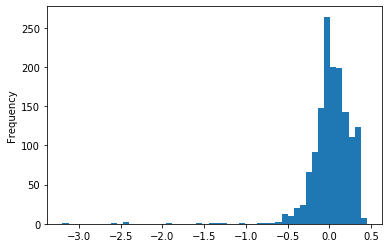

In [19]:
log10_diff = pd.np.log10(HY_orig.Y / Y_national_median)
substantial_area = A > 50 * 1e-3 # * 1e-3 for kha

log10_diff.reindex(substantial_area[substantial_area].index).plot.hist(bins=50)

In [20]:
log10_diff_limit = .75
too_large_diff = log10_diff.abs() > log10_diff_limit
suspect_case = too_large_diff & substantial_area

display(log10_diff[suspect_case])

suspect_geo_crop_combinations = suspect_case[suspect_case].index

geo   crops
DK    G1000   -2.399867
DK0   G1000   -2.399867
EL    G1000   -3.197069
      G2000   -1.036244
EL1   G1000   -1.918093
ES24  G1000   -0.766480
ES4   C1120   -1.253528
ES41  C1120   -1.531119
ES42  C1120   -1.407636
IT    G1000   -2.590665
ITG   C1300   -0.805577
RO    G1000   -1.341453
Name: Y, dtype: float64

In [21]:
context_data = (
    eust
    .read_table_data('apro_cpshr')
    .value
    .reorder_levels(['geo', 'crops', 'time', 'strucpro'])
    .unstack()
    .assign(YI_calc=lambda d: d.PR_HU_EU / d.AR)
    .join(
        (
            eust.read_table_data('ef_lus_allcrops')
            .value
            .xs('HA', level='unit')
            .xs('TOTAL', level='agrarea')
            .mul(1e-3)
            .rename('MA (FSS)')
            .reorder_levels(['geo', 'crops', 'time'])
        ),
        how='left'
    )
    .round(2)
    .sort_index()
    .join(
        HY_orig
        .assign(time=settings.DATA_YEAR)
        .reset_index()
        .set_index(['geo', 'crops', 'time']),
    )
    .stack()
    .loc[:, :, 2010:2016]
)
correction_factors = {}

In [22]:
# Looks like DK0 G1000 is reported factor 1000 wrong for year 2013
display(context_data.loc['DK':'DK0', 'G1000'].unstack())
correction_factors['DK', 'G1000', 2013] = 1e3
correction_factors['DK0', 'G1000', 2013] = 1e3

AR  HU_EU  PR_HU_EU  YI_HU_EU  YI_calc  MA (FSS)         H  \
geo crops time                                                                  
DK  G1000 2010  332.9   65.0  14150.40     37.20    42.51       NaN       NaN   
          2011  333.9   65.0  15660.00     47.80    46.90       NaN       NaN   
          2012  319.0   65.0  15783.30     49.50    49.48       NaN       NaN   
          2013    NaN    NaN       NaN       NaN      NaN    320.13  0.010924   
          2014  320.1   65.0  14220.30     44.40    44.42       NaN       NaN   
          2015  257.2   65.0  17978.14       NaN    69.90       NaN       NaN   
          2016  257.2   65.0  19680.14     71.67    76.52    269.98       NaN   
DK0 G1000 2010  332.9   65.0  14150.40       NaN    42.51       NaN       NaN   
          2011  333.9   65.0  15660.00       NaN    46.90       NaN       NaN   
          2012  319.0   65.0  15783.30       NaN    49.48       NaN       NaN   
          2013  316.0   65.0     13.57       NaN     0.04       NaN  0.010924   
          2014  320.1   65.0  14220.30       NaN    44.42       NaN       NaN   
          2015    NaN   65.0       NaN       NaN      NaN       NaN       NaN   
          2016    NaN   65.0       NaN       NaN      NaN       NaN       NaN   

                       Y  
geo crops time            
DK  G1000 2010       NaN  
          2011       NaN  
          2012       NaN  
          2013  0.034123  
          2014       NaN  
          2015       NaN  
          2016       NaN  
DK0 G1000 2010       NaN  
          2011       NaN  
          2012       NaN  
          2013  0.034123  
          2014       NaN  
          2015       NaN  
          2016       NaN

In [23]:
# Comparing Greece to Spain for reference
# Looks like EL G1000 might be reported factor 1000 wrong for years 2010-2014,
# and factor 100 wrong 2015-2016?
# Not sure, but this adjustment is probably better than nothing.
display(context_data.loc[['EL', 'EL1', 'ES'], 'G1000':'G2000'].unstack())
correction_factors['EL', 'G1000', 2013] = 1e3
correction_factors['EL1', 'G1000', 2013] = 1e3

AR  HU_EU  PR_HU_EU  YI_HU_EU  YI_calc  MA (FSS)  \
geo crops time                                                         
EL  G1000 2010  118.58   65.0      1.84      0.01     0.02       NaN   
          2011  114.44   65.0      2.57      0.02     0.02       NaN   
          2012  105.25   65.0      2.01      0.02     0.02       NaN   
          2013  111.08   65.0      0.75      0.01     0.01    110.92   
          2014  121.85   65.0      1.81      0.01     0.01       NaN   
          2015  111.12   65.0     20.71      0.19     0.19       NaN   
          2016  109.83   65.0     14.02      0.13     0.13    123.06   
    G2000 2010    9.07   65.0     37.40      4.12     4.12       NaN   
          2011   11.61   65.0     73.93      6.37     6.37       NaN   
          2012   11.23   65.0    126.21     11.24    11.24       NaN   
          2013   15.76   65.0     88.41      5.61     5.61     58.74   
          2014   13.59   65.0     61.71      4.54     4.54       NaN   
          2015   19.07   65.0    111.74      5.86     5.86       NaN   
          2016   25.97   65.0    141.72      5.46     5.46     90.61   
EL1 G1000 2010  758.55   65.0     19.89       NaN     0.03       NaN   
          2011  854.37   65.0     11.24       NaN     0.01       NaN   
          2012  890.90   65.0      9.94       NaN     0.01       NaN   
          2013  699.75   65.0      8.45       NaN     0.01       NaN   
          2014  495.05   65.0     42.85       NaN     0.09       NaN   
          2015     NaN   65.0       NaN       NaN      NaN       NaN   
          2016     NaN   65.0       NaN       NaN      NaN       NaN   
    G2000 2010    1.46   65.0     29.91       NaN    20.49       NaN   
          2011    6.11   65.0     63.34       NaN    10.37       NaN   
          2012    8.21   65.0    111.43       NaN    13.57       NaN   
          2013   11.49   65.0     63.85       NaN     5.56       NaN   
          2014   10.53   65.0     86.75       NaN     8.24       NaN   
          2015     NaN   65.0       NaN       NaN      NaN       NaN   
          2016     NaN   65.0       NaN       NaN      NaN       NaN   
ES  G1000 2010  263.24   65.0   5995.79       NaN    22.78       NaN   
          2011  279.18   65.0   5728.66       NaN    20.52       NaN   
          2012  276.78    NaN       NaN       NaN      NaN       NaN   
          2013  278.08    NaN       NaN       NaN      NaN    263.81   
          2014  278.26    NaN       NaN       NaN      NaN       NaN   
          2015  274.64   65.0   3882.32     14.14    14.14       NaN   
          2016  289.47   65.0   4076.97     14.08    14.08    245.08   
    G2000 2010  388.68   65.0   4700.40       NaN    12.09       NaN   
          2011  380.96   65.0   4804.22       NaN    12.61       NaN   
          2012  392.46   65.0   3817.90       NaN     9.73       NaN   
          2013  379.54    NaN       NaN       NaN      NaN    160.23   
          2014  396.06    NaN       NaN       NaN      NaN       NaN   
          2015  412.15   65.0   7139.87     17.32    17.32       NaN   
          2016  425.58   65.0   8350.15     19.62    19.62    212.09   

                       H          Y  
geo crops time                       
EL  G1000 2010       NaN        NaN  
          2011       NaN        NaN  
          2012       NaN        NaN  
          2013  0.000604   0.005443  
          2014       NaN        NaN  
          2015       NaN        NaN  
          2016       NaN        NaN  
    G2000 2010       NaN        NaN  
          2011       NaN        NaN  
          2012       NaN        NaN  
          2013  0.092830   1.580363  
          2014       NaN        NaN  
          2015       NaN        NaN  
          2016       NaN        NaN  
EL1 G1000 2010       NaN        NaN  
          2011       NaN        NaN  
          2012       NaN        NaN  
          2013  0.006802   0.103472  
          2014       NaN        NaN  
          2015       NaN        NaN  
          2016 

In [24]:
# Nothing obviously wrong here. Probably just low harvests in ES4.
display(context_data.loc[['ES', 'ES4', 'ES41', 'ES42'], 'C1110':'C1120', 2013].unstack())

AR  HU_EU  PR_HU_EU  YI_HU_EU  YI_calc  MA (FSS)  \
geo  crops time                                                          
ES   C1110 2013  1781.58   14.0   7088.86      3.91     3.98   1746.44   
     C1111 2013  1660.73   14.0   6492.53      3.91     3.91       NaN   
     C1112 2013   120.86   14.0    573.02       NaN     4.74       NaN   
     C1120 2013   343.39   14.0    976.56      2.68     2.84    539.03   
ES4  C1110 2013  1191.95   14.0   4663.98       NaN     3.91       NaN   
     C1111 2013  1084.23   14.0   4101.40       NaN     3.78       NaN   
     C1112 2013      NaN   14.0       NaN       NaN      NaN       NaN   
     C1120 2013     8.47   14.0     23.95       NaN     2.83       NaN   
ES41 C1110 2013   818.08   14.0   3577.68       NaN     4.37    792.38   
     C1111 2013   731.80   14.0   3088.24       NaN     4.22       NaN   
     C1112 2013      NaN   14.0       NaN       NaN      NaN       NaN   
     C1120 2013     1.38   14.0      5.67       NaN     4.11     57.44   
ES42 C1110 2013   298.92   14.0    932.20       NaN     3.12    281.11   
     C1111 2013   277.48   14.0    859.07       NaN     3.10       NaN   
     C1112 2013      NaN   14.0       NaN       NaN      NaN       NaN   
     C1120 2013     2.48   14.0      7.01       NaN     2.83     53.44   

                         H          Y  
geo  crops time                        
ES   C1110 2013  21.947111  12.566770  
     C1111 2013  20.100873        NaN  
     C1112 2013   1.774070        NaN  
     C1120 2013   3.023430   5.609019  
ES4  C1110 2013  14.439682  12.525531  
     C1111 2013  12.697934        NaN  
     C1112 2013        NaN        NaN  
     C1120 2013   0.074149   0.579110  
ES41 C1110 2013  11.076497  13.978769  
     C1111 2013   9.561191        NaN  
     C1112 2013        NaN        NaN  
     C1120 2013   0.017554   0.305611  
ES42 C1110 2013   2.886091  10.266768  
     C1111 2013   2.659681        NaN  
     C1112 2013        NaN        NaN  
     C1120 2013   0.021703   0.406118

In [29]:
# Not sure what's wrong with the IT G1000 production value,
# but since subnational data are available let's drop the value
display(HY_orig.loc['IT', 'G1000'])
display(
    context_data
    .loc['IT':'ITX', ['G1000', 'G2000', 'G3000']]
    .unstack()
    .loc[lambda d: d[['AR', 'PR_HU_EU']].notnull().all(axis=1)]
    .loc[lambda d: d.index.get_level_values('geo').str.len() <= 3]
)
correction_factors['IT', 'G1000', 2013] = float('nan')

H    0.022540
Y    0.021991
Name: (IT, G1000), dtype: float64

AR  HU_EU  PR_HU_EU  YI_calc  MA (FSS)         H  \
geo crops time                                                          
IT  G1000 2013   252.90   65.0     28.00     0.11   1024.95   0.02254   
          2016   807.19   65.0  12329.60    15.27   1093.54       NaN   
    G2000 2016  1129.96   65.0  26760.00    23.68    128.53       NaN   
    G3000 2010   282.58   65.0  14088.60    49.86       NaN       NaN   
          2013   326.71   65.0  18423.66    56.39    274.83  13.54139   
          2014   342.74   65.0  22676.22    66.16       NaN       NaN   
          2016   325.04   65.0  20423.98    62.84    275.23       NaN   
          2011   297.45   65.0  15620.80    52.52       NaN       NaN   
          2012   296.31   65.0  15151.40    51.13       NaN       NaN   
ITC G1000 2016   120.03   65.0   3570.30    29.75       NaN       NaN   
    G2000 2016   133.67   65.0   4777.70    35.74       NaN       NaN   
    G3000 2016   196.05   65.0  12773.62    65.15       NaN       NaN   
ITD G3000 2011    75.82   65.0   3959.20    52.22       NaN       NaN   
ITE G3000 2011    29.43   65.0   1436.00    48.79       NaN       NaN   
ITF G1000 2016   223.21   65.0   2230.30     9.99       NaN       NaN   
    G2000 2016   221.97   65.0   3225.80    14.53       NaN       NaN   
    G3000 2016    24.50   65.0   1321.60    53.94       NaN       NaN   
ITG G1000 2016   281.24   65.0   2934.20    10.43       NaN       NaN   
    G2000 2016   169.31   65.0   1949.40    11.51       NaN       NaN   
    G3000 2016     7.92   65.0    262.08    33.09       NaN       NaN   
          2011     9.31   65.0    292.90    31.46       NaN       NaN   
ITH G1000 2016    36.93   65.0    739.70    20.03       NaN       NaN   
    G2000 2016   308.96   65.0  11884.40    38.47       NaN       NaN   
    G3000 2016    69.37   65.0   4419.15    63.70       NaN       NaN   
ITI G1000 2016   145.78   65.0   2855.10    19.58       NaN       NaN   
    G2000 2016   296.05   65.0   4922.70    16.63       NaN       NaN   
    G3000 2016    27.20   65.0   1647.53    60.57       NaN       NaN   

                        Y  YI_HU_EU  
geo crops time                       
IT  G1000 2013   0.021991       NaN  
          2016        NaN       NaN  
    G2000 2016        NaN       NaN  
    G3000 2010        NaN     52.83  
          2013  49.271878      9.38  
          2014        NaN      5.95  
          2016        NaN      5.55  
          2011        NaN      9.80  
          2012        NaN      9.80  
ITC G1000 2016        NaN       NaN  
    G2000 2016        NaN       NaN  
    G3000 2016        NaN       NaN  
ITD G3000 2011        NaN       NaN  
ITE G3000 2011        NaN       NaN  
ITF G1000 2016        NaN       NaN  
    G2000 2016        NaN       NaN  
    G3000 2016        NaN       NaN  
ITG G1000 2016        NaN       NaN  
    G2000 2016        NaN       NaN  
    G3000 2016        NaN       NaN  
          2011        NaN       NaN  
ITH G1000 2016        NaN       NaN  
    G2000 2016        NaN       NaN  
    G3000 2016        NaN       NaN  
ITI G1000 2016        NaN       NaN  
    G2000 2016        NaN       NaN  
    G3000 2016        NaN       NaN

In [30]:
# Nothing obviously wrong with ITG C1300
display(
    context_data
    .loc['ITG':'ITHX', ['C1000', 'C1200', 'C1300']]
    .unstack()
    .loc[lambda d: d['AR'] > 1]
)

AR  HU_EU  PR_HU_EU  YI_calc         H         Y  \
geo  crops time                                                         
ITG  C1000 2010  392.45   14.0    985.33     2.51       NaN       NaN   
           2011  378.92   14.0   1004.23     2.65       NaN       NaN   
           2013   39.20   14.0     87.08     2.22       NaN       NaN   
           2014  358.63   14.0    956.50     2.67       NaN       NaN   
     C1300 2010   25.82   14.0     49.43     1.91       NaN       NaN   
           2011   24.07   14.0     49.42     2.05       NaN       NaN   
           2012   18.38   14.0     52.65     2.86       NaN       NaN   
           2013   16.70   14.0     33.43     2.00  0.103499  1.840969   
           2014   16.56   14.0     36.45     2.20       NaN       NaN   
           2015   18.34   14.0     45.07     2.46       NaN       NaN   
           2016   18.29   14.0     44.72     2.45       NaN       NaN   
ITG1 C1000 2010  330.24   14.0    877.52     2.66       NaN       NaN   
           2011  317.71   14.0    888.43     2.80       NaN       NaN   
           2013   16.57   14.0     42.36     2.56       NaN       NaN   
           2014  300.26   14.0    824.46     2.75       NaN       NaN   
     C1300 2010   13.34   14.0     31.01     2.32       NaN       NaN   
           2011   10.39   14.0     25.62     2.47       NaN       NaN   
           2012    7.51   14.0     19.81     2.64       NaN       NaN   
           2013    4.36   14.0     11.11     2.55  0.034397  1.468056   
           2014    4.47   14.0     12.83     2.87       NaN       NaN   
           2015    4.85   14.0     13.47     2.78       NaN       NaN   
           2016    4.80   14.0     13.16     2.74       NaN       NaN   
ITG2 C1000 2010   62.22   14.0    107.81     1.73       NaN       NaN   
           2011   61.21   14.0    115.80     1.89       NaN       NaN   
           2013   22.63   14.0     44.73     1.98       NaN       NaN   
           2014   58.37   14.0    132.04     2.26       NaN       NaN   
     C1300 2010   12.48   14.0     18.42     1.48       NaN       NaN   
           2011   13.67   14.0     23.79     1.74       NaN       NaN   
           2012   10.87   14.0     22.09     2.03       NaN       NaN   
           2013   12.34   14.0     22.32     1.81  0.069103  2.107433   
           2014   12.09   14.0     23.62     1.95       NaN       NaN   
           2015   13.49   14.0     31.60     2.34       NaN       NaN   
           2016   13.49   14.0     31.56     2.34       NaN       NaN   
ITH  C1300 2015   39.51   14.0    225.08     5.70       NaN       NaN   
           2016   42.75   14.0    255.09     5.97       NaN       NaN   
ITH3 C1300 2015   12.64   14.0     77.37     6.12       NaN       NaN   
           2016   16.69   14.0    104.36     6.25       NaN       NaN   
ITH4 C1300 2015    5.76   14.0     30.55     5.30       NaN       NaN   
           2016    6.00   14.0     30.70     5.12       NaN       NaN   
ITH5 C1300 2015   21.05   14.0    116.96     5.56       NaN       NaN   
           2016   20.00   14.0    119.79     5.99       NaN       NaN   

                 MA (FSS)  
geo  crops time            
ITG  C1000 2010       NaN  
           2011       NaN  
           2013       NaN  
           2014       NaN  
     C1300 2010       NaN  
           2011       NaN  
           2012       NaN  
           2013       NaN  
           2014       NaN  
           2015       NaN  
           2016       NaN  
ITG1 C1000 2010       NaN  
           2011       NaN  
           2013       NaN  
           2014       NaN  
     C1300 2010       NaN  
           2011       NaN  
           2012       NaN  
           2013     23.43  
           2014       NaN  
           2015       NaN  
           2016     23.68  
ITG2 C1000 2010       NaN  
           2011       NaN  
           2013       NaN  
           2014       NaN  
     C1300 2010       NaN  
           2011       NaN  
           2012       NaN  
           20

In [31]:
# Looks like RO G1000 is a little strange; MA and AR don't match.
# But G2000 and G3000 are much more important in area here, so let's ignore this one.
display(
    context_data
    .loc['RO', 'G0000':'GX', 2012:2014]
    .unstack()
    .loc[lambda d: d['AR'] > 1]
)

AR  HU_EU      MA  PR_HU_EU  YI_HU_EU  YI_calc  MA (FSS)  \
geo crops time                                                                 
RO  G0000 2012  874.37   65.0  873.20   5164.08      5.91     5.91       NaN   
          2013  859.71   65.0  858.75   5771.24      6.71     6.71    712.30   
          2014  859.60   65.0  858.49   6013.06      7.00     7.00       NaN   
    G1000 2012   25.83   65.0     NaN     49.29      1.91     1.91       NaN   
          2013   26.34   65.0     NaN     51.44      1.95     1.95    106.08   
          2014   22.14   65.0     NaN     49.41      2.23     2.23       NaN   
    G2000 2012  624.14   65.0     NaN   2071.27      3.32     3.32       NaN   
          2013  625.51   65.0     NaN   2373.36      3.79     3.79    484.25   
          2014  637.60   65.0     NaN   2574.08      4.04     4.04       NaN   
    G2100 2012  338.14   65.0     NaN   1209.10      3.58     3.58       NaN   
          2013  341.34   65.0     NaN   1370.13      4.01     4.01       NaN   
          2014  361.80   65.0     NaN   1517.81      4.20     4.20       NaN   
    G2900 2012  286.00   65.0     NaN    862.17      3.02     3.01       NaN   
          2013  284.16   65.0     NaN   1003.23      3.53     3.53       NaN   
          2014  275.80   65.0     NaN   1056.27      3.83     3.83       NaN   
    G3000 2012   49.88   65.0     NaN    930.15     18.65    18.65       NaN   
          2013   56.31   65.0     NaN   1259.93     22.38    22.37     32.89   
          2014   48.27   65.0     NaN   1351.55     28.00    28.00       NaN   
    G9100 2013    1.34   65.0     NaN     18.62     13.89    13.90       NaN   
    G9900 2012  173.73   65.0     NaN   2105.75     12.12    12.12       NaN   
          2013  150.22   65.0     NaN   2067.88     13.77    13.77       NaN   
          2014  150.78   65.0     NaN   2024.12     13.42    13.42       NaN   

                       H          Y  
geo crops time                       
RO  G0000 2012       NaN        NaN  
          2013       NaN        NaN  
          2014       NaN        NaN  
    G1000 2012       NaN        NaN  
          2013  0.041409   0.390358  
          2014       NaN        NaN  
    G2000 2012       NaN        NaN  
          2013  2.492028   5.146160  
          2014       NaN        NaN  
    G2100 2012       NaN        NaN  
          2013  1.438637        NaN  
          2014       NaN        NaN  
    G2900 2012       NaN        NaN  
          2013  1.053392        NaN  
          2014       NaN        NaN  
    G3000 2012       NaN        NaN  
          2013  0.926049  28.155930  
          2014       NaN        NaN  
    G9100 2013  0.016293        NaN  
    G9900 2012       NaN        NaN  
          2013  1.809395        NaN  
          2014       NaN        NaN

## Apply the correction factors

In [35]:
Y_orig = HY_orig.Y.dropna()
Y_corrected = Y_orig.copy(deep=True)

for (geo, crop, year), factor in correction_factors.items():
    assert year == settings.DATA_YEAR
    Y_corrected.loc[geo, crop] *= factor
    
Y_corrected[Y_corrected != Y_orig]

geo  crops
DK   G1000     34.123169
DK0  G1000     34.123169
EL   G1000      5.443112
EL1  G1000    103.472011
IT   G1000           NaN
Name: Y, dtype: float64

## Copy yield down to subregions where values are missing

In [36]:
Y_filled = (
    Y_corrected
    .pipe(hierarchy.fill_copy_to_children, nuts.get_nuts_aggregates(), level='geo', iterate=True)
    .sort_index()
)
Y_filled

geo   crops     
AT    C1000X1500    15.540189
      C1100         16.630838
      C1110         16.617218
      C1120         16.968875
      C1200         12.421926
                      ...    
UKN0  I1140         10.246353
      J1000         17.062468
      J2000         17.062468
      R1000         28.496241
      R2000         36.037962
Name: Y, Length: 6762, dtype: float64

## Set unproductive crops' yields to 0

This is just a computational convenience. We're interested in the average productivity on the reference area. If these "crops" (fallow and unused grassland) are included in the reference area, then their lack of production should be included in the mean.

In [37]:
NON_PRODUCTIVE_CROPS

['Q0000', 'J3000']

In [38]:
Y_filled = Y_filled.unstack().assign(**{k: 0 for k in NON_PRODUCTIVE_CROPS}).stack()
Y_filled.head()

geo  crops     
AT   C1000X1500    15.540189
     C1100         16.630838
     C1110         16.617218
     C1120         16.968875
     C1200         12.421926
dtype: float64

## Calculate gap-filled P harvest data

This will equal the previous result where there is harvest data. Where harvest data is missing but areas available, it creates an estimate corresponding to the assumption that yields are the same as in the parent region.

In [39]:
H_filled = Y_filled.mul(A).dropna()
H_filled.round(1)

geo   crops     
AT    C1000X1500    9.1
      C1100         4.9
      C1110         4.8
      C1120         0.2
      C1200         0.8
                   ... 
UKN0  J2000         3.3
      J3000         0.0
      Q0000         0.0
      R1000         0.1
      R2000         0.0
Length: 7126, dtype: float64

## Find the most aggregated set of available crops for each region

In [40]:
def take_highest(s, aggregates, labels):
    assert isinstance(s, pd.Series)
    assert len(s.index.names) == 1, s.index.names
    candidates = set(labels)
    results = set()
    while candidates:
        found = candidates & set(s.index)        
        results.update(found)
        
        not_found = candidates - found
        candidates = set()
        for item in not_found:
            if item in aggregates:
                children = aggregates[item]
                candidates.update(children)
            else:
                results.add(item)
        results.update(found)
    return s.reindex(results)


In [41]:
def get_most_aggregated_crop_data():
    # included region/crop combinations
    incl = (
        H_filled
        .groupby(level='geo')
        .apply(lambda s: take_highest(s.droplevel('geo'), CROP_PARTITIONS, INCLUDED_CROPS))
        .index
    )
    
    return (
        pd.DataFrame({
            'Y': Y_filled,
            'A': A,
            'a': A.div(A.xs('UAA', level='crops'), axis=0),
            'H': H_filled
        })
        .reindex(incl)
        .rename_axis('variable', axis=1)
#         .sort_index(axis=1)
        .reindex(['Y', 'a', 'A', 'H'], axis=1)
    )    

most_aggregated_crop_data = get_most_aggregated_crop_data()
most_aggregated_crop_data

variable                      Y         a        A         H
geo  crops                                                  
AT   O1100                  NaN  0.000000  0.00000       NaN
     R1000            19.749416  0.007851  0.02141  0.422835
     C2200                  NaN       NaN      NaN       NaN
     I1110            22.839156  0.020995  0.05725  1.307542
     T9000                  NaN       NaN      NaN       NaN
...                         ...       ...      ...       ...
UKN0 W1300                  NaN  0.000000  0.00000       NaN
     W1190                  NaN  0.000000  0.00000       NaN
     C1600_1700_1900   7.951495  0.000287  0.00030  0.002385
     G9100                  NaN       NaN      NaN       NaN
     I1140            10.246353  0.000000  0.00000  0.000000

[15417 rows x 4 columns]

## Check area coverage on NUTS 0/1/2 levels

In [42]:
uaa_by_country = A.xs('UAA', level='crops').reindex(EU28_COUNTRIES)
uaa_by_country

geo
AT     2.72689
BE     1.30790
BG     4.65094
CY     0.10933
CZ     3.49147
DE    16.69958
DK     2.61934
EE     0.95751
EL     4.85678
ES    23.30022
FI     2.25763
FR    27.73943
HR     1.57120
HU     4.65652
IE     4.95945
IT    12.09889
LT     2.86125
LU     0.13104
LV     1.87772
MT     0.01088
NL     1.84757
PL    14.40987
PT     3.64159
RO    13.05585
SE     3.02862
SI     0.48576
SK     1.90161
UK    17.09617
dtype: float64

In [43]:
most_aggregated_crop_data

variable                      Y         a        A         H
geo  crops                                                  
AT   O1100                  NaN  0.000000  0.00000       NaN
     R1000            19.749416  0.007851  0.02141  0.422835
     C2200                  NaN       NaN      NaN       NaN
     I1110            22.839156  0.020995  0.05725  1.307542
     T9000                  NaN       NaN      NaN       NaN
...                         ...       ...      ...       ...
UKN0 W1300                  NaN  0.000000  0.00000       NaN
     W1190                  NaN  0.000000  0.00000       NaN
     C1600_1700_1900   7.951495  0.000287  0.00030  0.002385
     G9100                  NaN       NaN      NaN       NaN
     I1140            10.246353  0.000000  0.00000  0.000000

[15417 rows x 4 columns]

In [44]:
def get_covered_area(nuts_level):
    covered_items = most_aggregated_crop_data.dropna(how='any')
    
    return (
        covered_items
        .pipe(nuts.filter_nuts_level, nuts_level)
        .join(NUTS_TABLE.country_code)
        .groupby('country_code')
        .sum()
        .A
    )

coverage = (
    pd.DataFrame({
        nuts_level: get_covered_area(nuts_level)
        for nuts_level in [0, 1, 2]
        },
    )
    .div(uaa_by_country, axis=0)
    .round(2)
)
coverage.columns.name = 'nuts_level'
coverage

nuts_level,0,1,2
country_code,,,
AT,0.97,0.94,0.97
BE,0.93,0.92,0.93
BG,0.97,0.97,0.97
CY,0.87,0.87,0.87
CZ,0.97,0.97,0.97
DE,0.94,0.94,0.94
DK,0.92,0.92,0.92
EE,0.81,0.81,0.81
EL,0.90,0.90,0.90


In [45]:
COVERAGE_WARNING_BELOW = 0.85

coverage[(coverage < COVERAGE_WARNING_BELOW).any(axis=1)]

nuts_level,0,1,2
country_code,,,
EE,0.81,0.81,0.81
IT,0.76,0.70,0.76
LV,0.78,0.78,0.78
MT,0.67,0.67,0.67
NL,0.79,0.78,0.79
PT,0.84,0.83,0.84


In [46]:
final_crop_data = most_aggregated_crop_data.dropna()
final_crop_data.round(2)

variable                  Y     a     A     H
geo  crops                                   
AT   R1000            19.75  0.01  0.02  0.42
     I1110            22.84  0.02  0.06  1.31
     Q0000             0.00  0.01  0.04  0.00
     C1500            18.10  0.09  0.23  4.23
     I1120            12.90  0.01  0.02  0.28
...                     ...   ...   ...   ...
UKN0 C1300            16.11  0.03  0.03  0.43
     R1000            28.50  0.00  0.00  0.13
     C1500            19.25  0.00  0.00  0.00
     C1600_1700_1900   7.95  0.00  0.00  0.00
     I1140            10.25  0.00  0.00  0.00

[5820 rows x 4 columns]

In [47]:
final_crop_data.to_csv(settings.CROP_DATA_PATH)

In [48]:
P_harvest_per_ha = final_crop_data.groupby('geo').sum().eval('H / A').rename('Y')
P_harvest_per_ha

geo
AT      12.763447
AT1     14.267497
AT11    12.477930
AT12    15.395824
AT13     9.708298
          ...    
UKM3    17.129670
UKM5    17.511307
UKM6    17.069488
UKN     17.124204
UKN0    17.124204
Name: Y, Length: 397, dtype: float64

DEBUG:fiona.env:Entering env context: <fiona.env.Env object at 0x7f7394d15f98>
DEBUG:fiona.env:Starting outermost env
DEBUG:fiona.env:No GDAL environment exists
DEBUG:fiona.env:New GDAL environment <fiona._env.GDALEnv object at 0x7f7394d15da0> created
DEBUG:fiona._env:Logging error handler pushed.
DEBUG:fiona._env:All drivers registered.
DEBUG:fiona._env:GDAL_DATA found in environment: '/home/rasmus/.local/share/virtualenvs/eu-p-budget-YA21ty_Y/lib/python3.6/site-packages/fiona/gdal_data'.
DEBUG:fiona._env:PROJ data files are available at built-in paths
DEBUG:fiona._env:Started GDALEnv <fiona._env.GDALEnv object at 0x7f7394d15da0>.
DEBUG:fiona.env:Updated existing <fiona._env.GDALEnv object at 0x7f7394d15da0> with options {}
DEBUG:fiona.env:Entered env context: <fiona.env.Env object at 0x7f7394d15f98>
DEBUG:fiona.ogrext:Got coordinate system
DEBUG:fiona.ogrext:Got coordinate system
DEBUG:fiona.ogrext:Index: 0
DEBUG:fiona.collection:Flushed buffer
DEBUG:fiona.collection:Stopped session


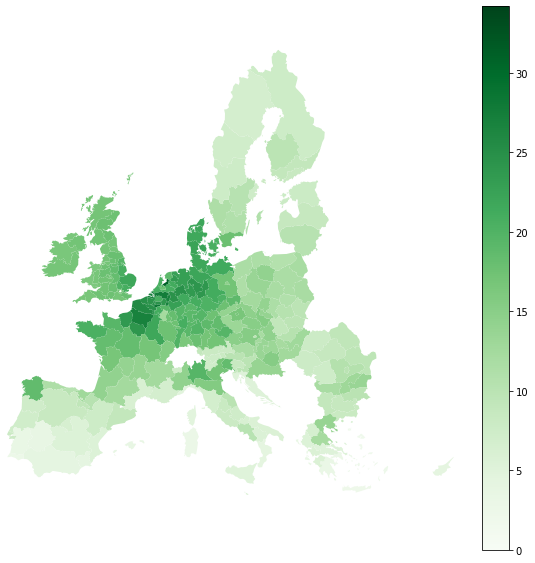

In [49]:
nuts_geo = geopandas.read_file(settings.NUTS_GIS_PATH).set_index('NUTS_ID')
ax = (
    nuts_geo
    .join(P_harvest_per_ha, how='inner')
    .pipe(nuts.filter_nuts_level, 2)
    .plot('Y', legend=True, cmap=mpl.cm.Greens, vmin=0)
    .axes
)
plots.adj_geoplot(ax)
ax.figure.set_size_inches(10, 10)

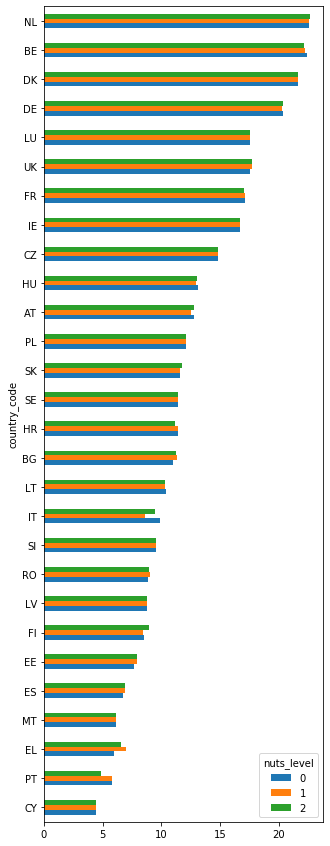

In [50]:
P_harvest_per_ha_by_country = (
    final_crop_data
    [['A', 'H']]
    .join(NUTS_TABLE[['country_code', 'nuts_level']], how='inner')
    .groupby(['country_code', 'nuts_level'])
    .sum()
    .eval('H/A')
    .rename('Y')
)

P_harvest_per_ha_by_country.unstack().sort_values(0).plot.barh(figsize=(5, 15))

# Calculate reference areas

In [51]:
# crops to exclude for each alternative
REFAREA_OPTIONS = {
    'A': [],
    'B': ['J3000'],
    'C': ['J2000', 'J3000'],
}

def calculate_refarea(excluded_crops):
    uaa = A.xs('UAA', level='crops').dropna()
    if not excluded_crops:
        return uaa
    excluded_area = (
        final_crop_data.A
        .reindex(excluded_crops, level='crops')
        .groupby('geo')
        .sum(skipna=False)
    )
    return uaa - excluded_area

refareas = pd.DataFrame({k: calculate_refarea(v) for k, v in REFAREA_OPTIONS.items()})
refareas

,A,B,C
geo,,,
AT,2.72689,2.72361,2.28822
AT1,1.09884,1.09803,1.08506
AT11,0.18197,0.18176,0.17671
AT12,0.90885,0.90831,0.90100
AT13,0.00802,0.00796,0.00735
...,...,...,...
UKM3,0.79834,0.79709,0.48694
UKM5,0.47877,0.47753,0.31144
UKM6,2.76356,2.75949,0.43391


## Check refarea coverage

In [52]:
refareas.reindex(NUTS_TABLE.index).loc[lambda d: d.isnull().any(axis=1)]

,A,B,C
geo,,,


In [53]:
refareas.to_csv(settings.REFERENCE_AREAS_PATH)

# Calculate and save harvest for each reference area

In [54]:
def get_total_harvest(excluded_crops):
    return (
        final_crop_data
        .H
        .loc[lambda s: ~s.index.get_level_values('crops').isin(excluded_crops)]
        .groupby('geo')
        .sum()
    )

In [55]:
refarea_harvests = pd.DataFrame(
    {
        k: get_total_harvest(v)
        for k, v in REFAREA_OPTIONS.items()
    }
)
refarea_harvests

,A,B,C
geo,,,
AT,33.678652,33.678652,30.142120
AT1,14.310585,14.310585,14.212358
AT11,2.159930,2.159930,2.129993
AT12,13.367578,13.367578,13.309229
AT13,0.064269,0.064269,0.061603
...,...,...,...
UKM3,11.629162,11.629162,6.336142
UKM5,6.501073,6.501073,3.666581
UKM6,45.362334,45.362334,5.673986


In [56]:
refarea_harvests.to_csv(settings.HARVEST_PATH)